# Simulation example with *thztools*

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi
from numpy.random import default_rng
from matplotlib.figure import figaspect

from scipy.signal import periodogram
from scipy.optimize import least_squares
from scipy.stats import cumfreq, chi2, norm, probplot

from thztools.thztools import thzgen, noiseamp, fftfreq, costfunlsq

## Simulate noisy terahertz time-domain waveforms

Functions from `thztools`: `thzgen`, `noiseamp`

The first cell below sets the parameters for the simulation, and the subsequent cell generates `n_sim = 11` noisy terahertz time-domain waveforms, each with `n = 256` samples, and stores them in an `(n_sim, n)` NumPy array `x`. The function `thzgen` returns discrete samples `mu` of an ideal waveform $\mu(t)$, evaluated at the measurement times `t`. The function `noiseamp` returns the noise amplitude $\sigma(t)$ at each point in the sampled waveform,  `sigma`, where
$$\sigma^2(t) = \sigma^2_\alpha + [\sigma_\beta\mu(t)]^2 + [\sigma_\tau\dot{\mu}(t)]^2$$
and $\dot{\mu}(t)$ denotes the time derivative of $\mu(t)$. We use the SciPy `periodogram` function to compute the power spectral density `psd` of the noisy sampled waveforms at the discrete frequencies `f`.

The next cell generates a figure shows (a) `mu` and `30 * sigma` and (b) the power spectral density as a function of frequency, normalized to the maximum value over all waveforms.

In [2]:
n = 256     # Number of samples
ts = 0.05   # Sampling time [ps]
t0 = 2.5    # Peak pulse time [ps]
fs = 1 / ts # Sampling frequency [THz]

sigma_alpha = 1e-4  # Additive noise amplitude [signal units]
sigma_beta = 1e-2   # Multiplicative noise amplitude [dimensionless]
sigma_tau = 1e-3    # Time base noise amplitude [ps]
sigma_parms = np.array([sigma_alpha, sigma_beta, sigma_tau])

seed = 0    # RNG seed
rng = default_rng(seed)

In [3]:
mu, t = thzgen(n, ts, t0)
sigma = noiseamp(sigma_parms, mu, ts)

# Use broadcasting to generate multiple simulated noisy measurements of y
n_sim = 11
x = mu + sigma * rng.standard_normal((n_sim, n))

# Compute power spectral density
f, psd = periodogram(x, fs=fs, detrend=False)
n_f = f.size

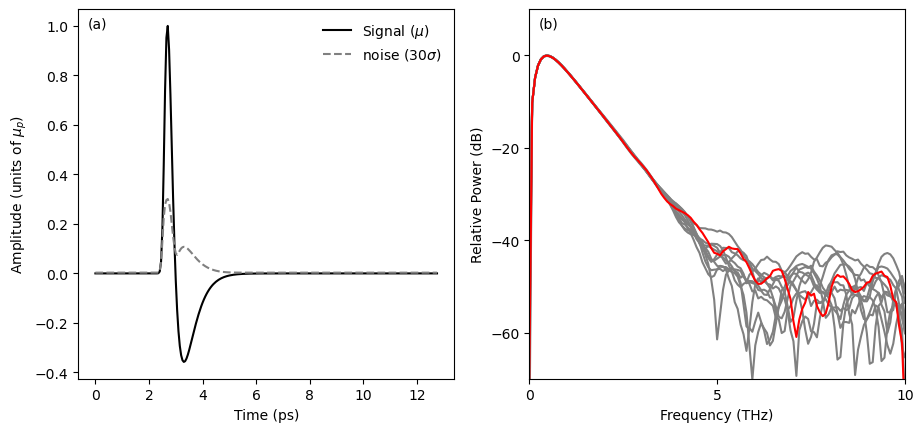

In [4]:
w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h))

axs[0].plot(t, mu, c='k', label=r'Signal ($\mu$)')
axs[0].plot(t, sigma * 30, ls='--', c='grey', label=r'noise $(30 \sigma$)')

axs[0].legend(frameon=False)
axs[0].text(0.025, 0.95, '(a)', transform=axs[0].transAxes)

axs[0].set_xlabel('Time (ps)')
axs[0].set_ylabel(r'Amplitude (units of $\mu_{p})$')

axs[1].plot(f, 10 * np.log10(psd[1:, :].T / max(psd.flatten())), c='grey')
axs[1].plot(f, 10 * np.log10(psd[0, :].T / max(psd.flatten())), c='red')

axs[1].text(0.025, 0.95, '(b)', transform=axs[1].transAxes)

axs[1].set_xlabel('Frequency (THz)')
axs[1].set_ylabel('Relative Power (dB)')

axs[1].set_xticks(np.arange(0, 11, 5))
axs[1].set_xlim(0, 10)
axs[1].set_yticks(np.arange(-60, 10, 20))
axs[1].set_ylim(-70, 10)

plt.show()

## Empirical transfer function estimates

In [5]:
# Clear x and n_sim for reuse
del x, n_sim

n_sim = 250
x = mu + sigma * rng.standard_normal((n_sim, n))
y = mu + sigma * rng.standard_normal((n_sim, n))

x_f = np.fft.rfft(x)
y_f = np.fft.rfft(y)
etfe = y_f / x_f

etfe_mean = np.mean(etfe, 0)

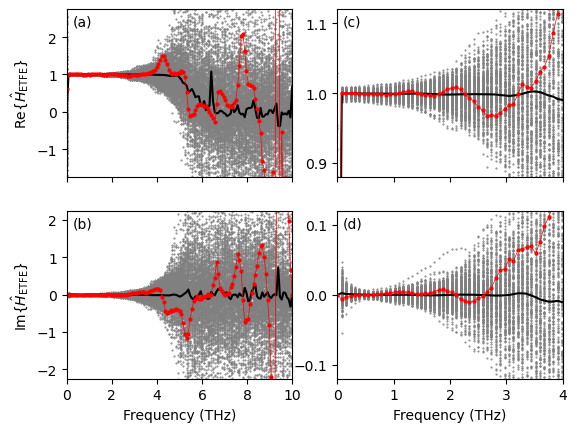

In [6]:
marker_size = 1
marker_size_highlight = 4
line_width_highlight = 0.5
_, axs = plt.subplots(2, 2, sharex='col')

axs[0, 0].plot(f, etfe.real[1:, :].T, '.',
               ms=marker_size,
               color='gray')
axs[0, 0].plot(f, etfe_mean.real, 'k-')
axs[0, 0].plot(f, etfe.real[0, :], 'r.-',
               ms=marker_size_highlight,
               lw=line_width_highlight)

axs[0, 0].text(0.025, 0.9, '(a)', transform=axs[0, 0].transAxes)

axs[1, 0].plot(f, etfe.imag[1:, :].T, '.',
               ms=marker_size,
               color='gray')
axs[1, 0].plot(f, etfe_mean.imag, 'k-')
axs[1, 0].plot(f, etfe.imag[0, :], 'r.-',
               ms=marker_size_highlight,
               lw=line_width_highlight)

axs[1, 0].text(0.025, 0.9, '(b)', transform=axs[1, 0].transAxes)

axs[0, 1].plot(f, etfe.real[1:, :].T, '.',
               ms=marker_size,
               color='gray')
axs[0, 1].plot(f, etfe_mean.real, 'k-')
axs[0, 1].plot(f, etfe.real[0, :], 'r.-',
               ms=marker_size_highlight,
               lw=line_width_highlight)

axs[0, 1].text(0.025, 0.9, '(c)', transform=axs[0, 1].transAxes)

axs[1, 1].plot(f, etfe.imag[1:, :].T, '.',
               ms=marker_size,
               color='gray')
axs[1, 1].plot(f, etfe_mean.imag, 'k-')
axs[1, 1].plot(f, etfe.imag[0, :], 'r.-',
               ms=marker_size_highlight,
               lw=line_width_highlight)

axs[1, 1].text(0.025, 0.9, '(d)', transform=axs[1, 1].transAxes)

axs[0, 0].set_ylim(-1.75, 2.75)
axs[0, 1].set_ylim(0.88, 1.12)
axs[1, 0].set_ylim(-2.25, 2.25)
axs[1, 1].set_ylim(-0.12, 0.12)

axs[0, 0].set_yticks(np.arange(-1, 3))
axs[0, 1].set_yticks(np.linspace(0.9, 1.1, 3, endpoint=True))
axs[1, 0].set_yticks(np.arange(-2, 3))
axs[1, 1].set_yticks(np.linspace(-0.1, 0.1, 3, endpoint=True))

axs[0, 0].set_ylabel(r'$\mathrm{Re}\{\hat{H}_\mathrm{ETFE}\}$')
axs[1, 0].set_ylabel(r'$\mathrm{Im}\{\hat{H}_\mathrm{ETFE}\}$')

axs[1, 0].set_xlim(0, 10)
axs[1, 1].set_xlim(0, 4)

axs[1, 0].set_xlabel('Frequency (THz)')
axs[1, 1].set_xlabel('Frequency (THz)')

plt.show()

## Fits to the empirical transfer function estimate

In [7]:
def tf_model(_p, _f):
    return _p[0] * np.exp(2 * pi * 1j * _f * _p[1])

def normres(_p, _f, _etfe, _sigma):
    _r = (_etfe - tf_model(_p, _f)) / _sigma
    return np.concatenate((_r.real, _r.imag))

sigma_etfe = np.std(etfe, axis=0)

In [8]:
p_etfe = np.empty((2, n_sim))
resnorm_etfe = np.empty((n_sim,))
residual_etfe = np.empty((n_f, n_sim), dtype=np.complex128)
cv_etfe = np.empty((2, 2, n_sim))
for i in range(n_sim):
    result = least_squares(lambda _p: normres(_p, f, etfe[i, :], sigma_etfe), (1,0))
    p_etfe[:, i] = result.x
    residual_etfe[:, i] = result.fun[:n_f] + 1j * result.fun[n_f:]
    resnorm_etfe[i] = 4 * result.cost
    if n_f % 2 != 0:
        resnorm_etfe[i] -= np.abs(residual_etfe[-1, i]) ** 2
    _, r = np.linalg.qr(result.jac)
    r_inv = np.linalg.inv(r)
    cv_etfe[:, :, i] = r_inv @ r_inv.T
    if not result.success:
        print(f"Fit did not converge at i = {i}")

cf_etfe = cumfreq(resnorm_etfe, 1000, defaultreallimits=(0, 1000))
gof_etfe = cf_etfe.lowerlimit + np.linspace(0, cf_etfe.binsize * cf_etfe.cumcount.size,
                          cf_etfe.cumcount.size)
ecdf_etfe = cf_etfe.cumcount / n_sim

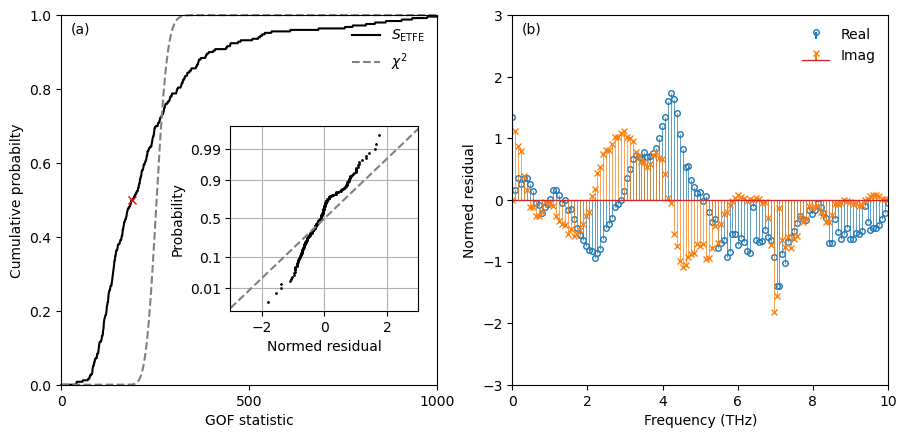

In [9]:
# Find the index of the median value
i_show = np.argsort(resnorm_etfe)[len(resnorm_etfe) // 2]
osm, osr = probplot(np.concatenate((residual_etfe[:, i_show].real,
                                    residual_etfe[:, i_show].imag)), fit=False)

w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h))

# Panel (a)
axs[0].plot(gof_etfe, ecdf_etfe, 'k-', label=r'$S_\mathrm{ETFE}$', clip_on=False)
axs[0].plot(gof_etfe, chi2.cdf(gof_etfe, n - 2), '--', c='gray', label=r'$\chi^2$', clip_on=False)
axs[0].plot(np.median(resnorm_etfe), 0.5, 'rx')

axs[0].legend(loc='upper right', frameon=False)
axs[0].text(0.025, 0.95, '(a)', transform=axs[0].transAxes)

axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 1)

axs[0].set_xticks([0, 500, 1000])
axs[0].set_yticks(np.linspace(0, 1, 6, endpoint=True))

axs[0].set_xlabel('GOF statistic')
axs[0].set_ylabel('Cumulative probabilty')

# Inset to (a)
ins = axs[0].inset_axes([0.45, 0.2, 0.5, 0.5])
ins.plot(osr, osm, 'k.', ms=2)
ins.plot([-3, 3], [-3, 3], '--', c='gray')
ins.grid()

ins.set_xlim(-3, 3)
ins.set_ylim(norm.ppf([0.001, 0.999]))

ins.set_xticks([-2, 0, 2])
ins.set_yticks(norm.ppf([0.01, 0.1, 0.5, 0.9, 0.99]))

ins.set_yticklabels(['0.01', '0.1', '0.5', '0.9', '0.99'])

ins.set_xlabel('Normed residual')
ins.set_ylabel('Probability')

# Panel (b)
markerline, stemlines, baseline = axs[1].stem(f, residual_etfe[:, i_show].real,
                                              linefmt = 'C0-', markerfmt='o',
                                              label='Real')
markerline.set_markerfacecolor('none')
markerline.set_markersize(4)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(0)

markerline, stemlines, baseline = axs[1].stem(f, residual_etfe[:, i_show].imag,
                                              linefmt = 'C1-', markerfmt='x',
                                              label='Imag')
markerline.set_markersize(4)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axs[1].legend(loc='upper right', frameon=False)
axs[1].text(0.025, 0.95, '(b)', transform=axs[1].transAxes)

axs[1].set_xlim(0, 10)
axs[1].set_ylim(-3, 3)

axs[1].set_xlabel('Frequency (THz)')
axs[1].set_ylabel('Normed residual')

plt.show()

In [10]:
print(f"Amplitude parameter estimates: "
      f"{np.mean(p_etfe[0, :]):.3f} ± {np.std(p_etfe[0, :]):.3f}")
print(f"Delay parameter estimates:     "
      f"({np.mean(1e3 * p_etfe[1, :]):.1f} ± {1e3 * np.std(p_etfe[1, :]):.1f}) fs")
print(f"Mean uncertainty estimate for amplitude parameter: "
      f"{np.mean(np.sqrt(cv_etfe[0, 0, :])):.4f}")
print(f"Mean uncertainty estimate for delay parameter:     "
      f"{1e3 * np.mean(np.sqrt(cv_etfe[1, 1, :])):.1f} fs")
print(f"Standard deviation of the amplitude parameter uncertainty estimate: "
      f"{np.std(np.sqrt(cv_etfe[0, 0, :])):.2g}")
print(f"Standard deviation of the delay parameter uncertainty estimate:     "
      f"{1e3 * np.std(np.sqrt(cv_etfe[1, 1, :])):.2g} fs")

Amplitude parameter estimates: 0.999 ± 0.005
Delay parameter estimates:     (-0.0 ± 0.7) fs
Mean uncertainty estimate for amplitude parameter: 0.0014
Mean uncertainty estimate for delay parameter:     0.3 fs
Standard deviation of the amplitude parameter uncertainty estimate: 1.6e-12
Standard deviation of the delay parameter uncertainty estimate:     0.0013 fs


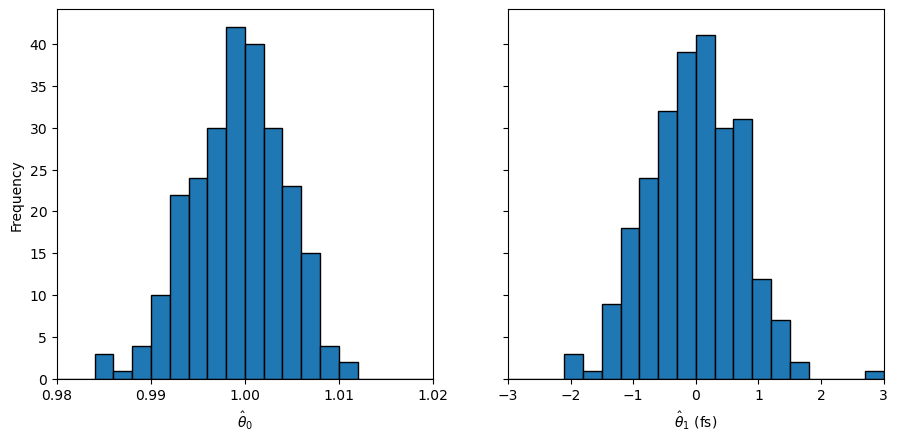

In [11]:
w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h), sharey=True)

axs[0].hist(p_etfe[0, :], bins=20, range=(0.98, 1.02), ec='k')

axs[0].set_xticks(np.arange(0.98, 1.021, 0.01))
axs[0].set_xlim(0.98, 1.02)

axs[0].set_xlabel(r'$\hat{\theta}_0$')
axs[0].set_ylabel('Frequency')

axs[1].hist(1e3 * p_etfe[1, :], bins=20, range=(-3, 3), ec='k')

axs[1].set_xticks(np.arange(-3, 3.1, 1))
axs[1].set_xlim(-3, 3)

axs[1].set_xlabel(r'$\hat{\theta}_1$ (fs)')

plt.show()

## Time-domain maximum-likelihood fits

In [12]:
def tf_model(_p, _w):
    return _p[0] * np.exp(1j * _w * _p[1])

p_mle = np.empty((2, n_sim))
resnorm_mle = np.empty((n_sim,))
residual_mle = np.empty((n, n_sim))
cv_mle = np.empty((2, 2, n_sim))
for i in range(n_sim):
    result = least_squares(lambda _p: costfunlsq(tf_model, _p, x[i, :], y[i, :],
                                                 sigma, sigma, 2 * pi * fftfreq(n, ts)),
                           (1,0))
    p_mle[:, i] = result.x
    residual_mle[:, i] = result.fun
    resnorm_mle[i] = 2 * result.cost
    _, r = np.linalg.qr(result.jac)
    r_inv = np.linalg.inv(r)
    cv_mle[:, :, i] = r_inv @ r_inv.T
    if not result.success:
        print(f"Fit did not converge at i = {i}")

cf_mle = cumfreq(resnorm_mle, 1000, defaultreallimits=(0, 1000))
gof_mle = cf_mle.lowerlimit + np.linspace(0, cf_mle.binsize * cf_mle.cumcount.size,
                          cf_mle.cumcount.size)
ecdf_mle = cf_mle.cumcount / n_sim

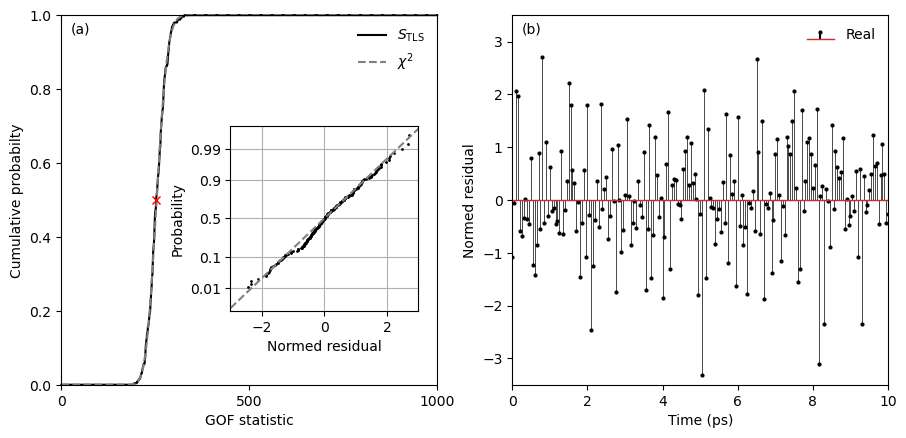

In [13]:
# Find the index of the median value
i_show = np.argsort(resnorm_mle)[len(resnorm_mle) // 2]
osm, osr = probplot(residual_mle[:, i_show], fit=False)

w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h))

# Panel (a)
axs[0].plot(gof_mle, ecdf_mle, 'k-', label=r'$S_\mathrm{TLS}$', clip_on=False)
axs[0].plot(gof_mle, chi2.cdf(gof_mle, n - 2), '--', c='gray', label=r'$\chi^2$', clip_on=False)
axs[0].plot(np.median(resnorm_mle), 0.5, 'rx')

axs[0].legend(loc='upper right', frameon=False)
axs[0].text(0.025, 0.95, '(a)', transform=axs[0].transAxes)

axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 1)

axs[0].set_xticks([0, 500, 1000])
axs[0].set_yticks(np.linspace(0, 1, 6, endpoint=True))

axs[0].set_xlabel('GOF statistic')
axs[0].set_ylabel('Cumulative probabilty')

# Inset to (a)
ins = axs[0].inset_axes([0.45, 0.2, 0.5, 0.5])
ins.plot(osr, osm, 'k.', ms=2)
ins.plot([-3, 3], [-3, 3], '--', c='gray')
ins.grid()

ins.set_xlim(-3, 3)
ins.set_ylim(norm.ppf([0.001, 0.999]))

ins.set_xticks([-2, 0, 2])
ins.set_yticks(norm.ppf([0.01, 0.1, 0.5, 0.9, 0.99]))

ins.set_yticklabels(['0.01', '0.1', '0.5', '0.9', '0.99'])

ins.set_xlabel('Normed residual')
ins.set_ylabel('Probability')

# Panel (b)
markerline, stemlines, baseline = axs[1].stem(t, residual_mle[:, i_show],
                                              linefmt = 'k-', markerfmt='.',
                                              label='Real')
markerline.set_markersize(4)
stemlines.set_linewidth(0.5)
baseline.set_linewidth(1)

axs[1].legend(loc='upper right', frameon=False)
axs[1].text(0.025, 0.95, '(b)', transform=axs[1].transAxes)

axs[1].set_xlim(0, 10)
axs[1].set_ylim(-3.5, 3.5)

axs[1].set_xlabel('Time (ps)')
axs[1].set_ylabel('Normed residual')

plt.show()

In [14]:
print(f"Amplitude parameter estimates: "
      f"{np.mean(p_mle[0, :]):.3f} ± {np.std(p_mle[0, :]):.3f}")
print(f"Delay parameter estimates:     "
      f"({np.mean(1e3 * p_mle[1, :]):.1f} ± {1e3 * np.std(p_mle[1, :]):.1f}) fs")
print(f"Mean uncertainty estimate for amplitude parameter: "
      f"{np.mean(np.sqrt(cv_mle[0, 0, :])):.4f}")
print(f"Mean uncertainty estimate for delay parameter:     "
      f"{1e3 * np.mean(np.sqrt(cv_mle[1, 1, :])):.1f} fs")
print(f"Standard deviation of the amplitude parameter uncertainty estimate: "
      f"{np.std(np.sqrt(cv_mle[0, 0, :])):.2g}")
print(f"Standard deviation of the delay parameter uncertainty estimate:     "
      f"{1e3 * np.std(np.sqrt(cv_mle[1, 1, :])):.2g} fs")

Amplitude parameter estimates: 1.000 ± 0.002
Delay parameter estimates:     (-0.0 ± 0.5) fs
Mean uncertainty estimate for amplitude parameter: 0.0023
Mean uncertainty estimate for delay parameter:     0.4 fs
Standard deviation of the amplitude parameter uncertainty estimate: 1.2e-05
Standard deviation of the delay parameter uncertainty estimate:     0.038 fs


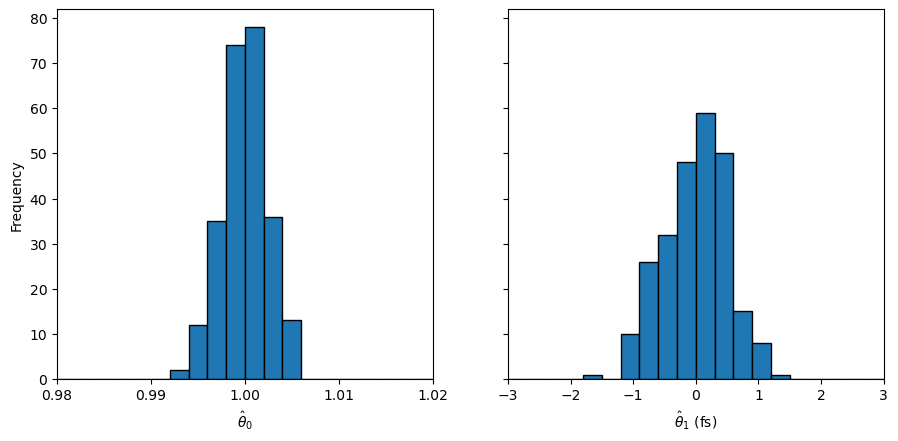

In [15]:
w, h = figaspect(0.45)
_, axs = plt.subplots(1, 2, figsize=(w, h), sharey=True)

axs[0].hist(p_mle[0, :], bins=20, range=(0.98, 1.02), ec='k')

axs[0].set_xticks(np.arange(0.98, 1.021, 0.01))
axs[0].set_xlim(0.98, 1.02)

axs[0].set_xlabel(r'$\hat{\theta}_0$')
axs[0].set_ylabel('Frequency')

axs[1].hist(1e3 * p_mle[1, :], bins=20, range=(-3, 3), ec='k')

axs[1].set_xticks(np.arange(-3, 3.1, 1))
axs[1].set_xlim(-3, 3)

axs[1].set_xlabel(r'$\hat{\theta}_1$ (fs)')

plt.show()